# B. ClaMP 데이터셋을 활용한, PE 파일의 header 및 일부 정적 정보를 이용한 악성 코드 탐지 및 분류 모델 작성

이번에는 탐지를 넘어 분류까지 해 봅시다.

이 노트북에서는 scikit-learn 모듈을 사용합니다.

In [1]:
import os, sys
import urllib.request
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras as keras
import keras as keras
from keras.utils import plot_model
import sklearn as sklearn

Using TensorFlow backend.


# 1. 학습자료 확보

이 노트북에서 사용하는 예제는 아래 링크에서 공개된 자료입니다.

아래 링크는 PE 헤더를 이용한 malware 탐지를 위해 필요한 PE 헤더의 분석 자료를 csv 형태로 제공합니다.

A Malware classifier dataset built with header fields’ values of Portable Executable files : https://github.com/urwithajit9/ClaMP

자세한 내용은 위 링크를 클릭하여 살펴보시기 바랍니다.

## 1-1. malware 분류 자료 다운받기

위 github에서 제공하는 여러 자료 중에서 세 가지 자료를 내려받습니다.

1. ClaMP_Integrated-5184.csv
    - ClaMP 메인 데이터셋
    - PE header에서 추출한 정보 및 PE 파일을 가공한 정보 등 악성 코드 여부 판별을 위한 정보 68종
    - 악성 코드 여부(class) 정보 1종(0 또는 1)
2. Malware_VT_report_without_Zipped_3817.csv
    - ClaMP 추가 데이터셋
    - Virus Total에서 크롤링한 정보가 담겨 있음
        - 의심스러운 파일의 MD5 hash
        - 그 파일을 악성 코드로 진단한 백신 등의 개수
        - 각 백신 회사의 진단명
3. Malware-2722_hash_size_entropy.csv
    - ClaMP 추가 데이터셋
        - 의심스러운 파일의 MD5 hash
        - 그 파일의 파일 크기
        - 그 파일의 entropy

In [2]:
ClaMP_dataset_filename = 'ClaMP_Integrated-5184.csv'
ClaMP_malware_class_filename = 'Malware_VT_report_without_Zipped_3817.csv'
ClaMP_malware_md5_filename = 'Malware-2722_hash_size_entropy.csv'

#아래 URL에서 필요한 CSV 파일을 다운로드합니다.
if not os.path.exists(ClaMP_dataset_filename):
    urllib.request.urlretrieve("https://raw.githubusercontent.com/urwithajit9/ClaMP/master/dataset/ClaMP_Integrated-5184.csv",
                               ClaMP_dataset_filename)
if not os.path.exists(ClaMP_malware_md5_filename):
    urllib.request.urlretrieve("https://raw.githubusercontent.com/urwithajit9/ClaMP/master/raw-samples-metadata/Malware-2722_hash_size_entropy.csv",
                               ClaMP_malware_md5_filename)
if not os.path.exists(ClaMP_malware_class_filename):
    urllib.request.urlretrieve("https://raw.githubusercontent.com/urwithajit9/ClaMP/master/raw-samples-metadata/Malware_VT_report_without_Zipped_3817.csv",
                               ClaMP_malware_class_filename)

In [3]:
original_data = pd.read_csv(ClaMP_dataset_filename)
print("# of samples  : %d" % (original_data.shape[0]))
print("# of malwares : %d" % (len(original_data[original_data['class'] == 1])))
print("# of benigns  : %d" % (len(original_data[original_data['class'] == 0])))
#마지막 컬럼은 악성코드 여부를 나타내는 결과이므로 feature가 아님!
print("# of features : %d" % (original_data.shape[1] - 1))

# of samples  : 5210
# of malwares : 2722
# of benigns  : 2488
# of features : 69


## 1-2. 자료 통합, 가공하기

ClaMP 메인 자료로는 악성 코드의 여부만을 학습할 수 있습니다. 하지만 조금 더 욕심을 내서, 악성 코드의 종류까지 학습할 수 있도록 자료를 약간 가공해 봅니다.

악성 코드의 종류는 매우 잘게 나누어져 있습니다. 따라서, 우선 악성 코드의 종류를 좀 단순화해 보기로 하겠습니다. 분류 기준은 Kaspersky 사의 탐지 결과를 사용합니다.

In [4]:
original_data = pd.read_csv(ClaMP_dataset_filename)
hash_data = pd.read_csv(ClaMP_malware_md5_filename)
class_data = pd.read_csv(ClaMP_malware_class_filename)
#일부 백신은 특정 악성 코드를 탐지하지 못하는 경우가 있습니다.
#이 경우 탐지 결과 필드가 비어있으므로 Unknown으로 채워 둡니다.
class_data = class_data.fillna('Unknown')

ClaMP 데이터셋에 수록된 malware들의 Kaspersky 탐지 결과를 보면 아래와 같습니다. malware가 2722개인데 종류가 Unknown을 포함하여 1780가지이므로 이건 학습에 사용할 수가 없습니다.

In [5]:
kaspersky_long_types = set([t for t in class_data.loc[:, "Kaspersky"] if type(t) == str and len(t) > 0])
print("Kaspersky malware types(long names, %d entries) : \n" % len(kaspersky_long_types), list(kaspersky_long_types)[:50])

Kaspersky malware types(long names, 1780 entries) : 
 ['Trojan.Win32.TDSS.ciwi', 'Backdoor.Win32.Agent.bykx', 'Trojan-Dropper.Win32.FrauDrop.bqm', 'Trojan.Win32.FakeAV.dhuz', 'Trojan.Win32.Menti.gnxc', 'Worm.Win32.Skor.anv', 'Backdoor.Win32.EggDrop.aoa', 'Trojan.Win32.Llac.cxsz', 'Worm.Win32.Ngrbot.kpb', 'Trojan.Win32.Menti.iryf', 'Packed.Win32.Krap.hq', 'Trojan.Win32.Scarsi.thr', 'Worm.Win32.VBNA.asfq', 'Trojan.Win32.Llac.dcro', 'Trojan-Ransom.Win32.Foreign.dhu', 'Trojan-Dropper.Win32.Injector.fohz', 'Trojan-Spy.Win32.Zbot.crgx', 'Trojan-Dropper.Win32.Mudrop.pja', 'Trojan-Dropper.MSIL.StubRC.amt', 'Trojan-Dropper.Win32.TDSS.exl', 'Trojan-Downloader.Win32.FraudLoad.hkv', 'Trojan-FakeAV.Win32.InternetSecurity2010.ce', 'Trojan-Dropper.Win32.Daws.aphh', 'Worm.Win32.WBNA.axz', 'Trojan-Spy.Win32.Zbot.czco', 'Trojan.Win32.Jorik.Shakblades.bky', 'Backdoor.Win32.Xtoober.hup', 'Trojan.Win32.FakeAV.oiac', 'HEUR:Hoax.Win32.MDefender.a', 'Trojan.Win32.Scar.fnfb', 'Trojan-Ransom.Win32.Agent.hqq', '

따라서 이러한 분류 중 첫 대분류(첫 번째 마침표 이전 항목)을 사용하려고 합니다. 또한 일부 검진 결과는 HEUR: 등으로 시작하므로 이것도 E떼어내고, Trojan-Dropper처럼 작동 방식에 대한 부가 설명도 아래처럼 떼어버립시다. 그러면 총 22가지의 분류 범주를 얻습니다.

아래에서 만든 kaspersky_short_types는 dict 형식입니다. 이 형식은 원래 긴 분류(위에서 나온 1780가지) 이름을, 짧게 줄인 22가지 분류 이름으로 매핑합니다.

In [6]:
kaspersky_short_types = dict([(t, (t.split('.')[0]).split(':')[-1].split('-')[-1]) for t in kaspersky_long_types])
kaspersky_short_types['Unknown'] = 'Unknown'
uniq_kaspersky_short_types = list(set(kaspersky_short_types.values()))
print("Kaspersky malware types(short names, %d entries) : \n" % len(uniq_kaspersky_short_types), uniq_kaspersky_short_types)
print('Mappings : ', kaspersky_short_types)

Kaspersky malware types(short names, 22 entries) : 
 ['Downloader', 'Hoax', 'PSWTool', 'Unknown', 'GameThief', 'SMTP', 'PSW', 'Packed', 'Dropper', 'Trojan', 'Virus', 'Ransom', 'Proxy', 'AdWare', 'Worm', 'Spy', 'RiskTool', 'DangerousObject', 'Backdoor', 'Clicker', 'HackTool', 'FakeAV']
Mappings :  {'Trojan.Win32.TDSS.ciwi': 'Trojan', 'Backdoor.Win32.Agent.bykx': 'Backdoor', 'Trojan-Dropper.Win32.FrauDrop.bqm': 'Dropper', 'Trojan.Win32.FakeAV.dhuz': 'Trojan', 'Trojan.Win32.Menti.gnxc': 'Trojan', 'Worm.Win32.Skor.anv': 'Worm', 'Backdoor.Win32.EggDrop.aoa': 'Backdoor', 'Trojan.Win32.Llac.cxsz': 'Trojan', 'Worm.Win32.Ngrbot.kpb': 'Worm', 'Trojan.Win32.Menti.iryf': 'Trojan', 'Packed.Win32.Krap.hq': 'Packed', 'Trojan.Win32.Scarsi.thr': 'Trojan', 'Worm.Win32.VBNA.asfq': 'Worm', 'Trojan.Win32.Llac.dcro': 'Trojan', 'Trojan-Ransom.Win32.Foreign.dhu': 'Ransom', 'Trojan-Dropper.Win32.Injector.fohz': 'Dropper', 'Trojan-Spy.Win32.Zbot.crgx': 'Spy', 'Trojan-Dropper.Win32.Mudrop.pja': 'Dropper', 'Troja

여기서 잠깐 우리가 가진 자료 형태를 살펴보면 아래와 같습니다.

In [7]:
original_data[:10]

,e_cblp,e_cp,e_cparhdr,e_maxalloc,e_sp,e_lfanew,NumberOfSections,CreationYear,FH_char0,FH_char1,...,sus_sections,non_sus_sections,packer,packer_type,E_text,E_data,filesize,E_file,fileinfo,class
0,144,3,4,65535,184,256,4,1,0,1,...,1,3,0,NoPacker,6.603616,5.443362,1181520,6.627552,1,0
1,144,3,4,65535,184,184,4,1,0,1,...,1,3,0,NoPacker,5.205926,2.123522,7680,5.318221,0,0
2,144,3,4,65535,184,272,5,1,0,1,...,1,4,0,NoPacker,6.238000,3.380859,57872,6.507758,1,0
3,144,3,4,65535,184,184,1,1,0,1,...,0,1,0,NoPacker,0.000000,0.000000,95616,4.575092,1,0
4,144,3,4,65535,184,224,5,1,0,1,...,1,4,0,NoPacker,6.355626,0.702621,48128,5.545531,1,0
5,80,2,4,65535,184,256,8,1,0,1,...,4,4,0,NoPacker,0.000000,0.000000,13411640,7.999277,1,0
6,144,3,4,65535,184,272,8,1,0,1,...,4,4,1,Armadillov1xxv2xx,6.595606,2.843601,397936,6.295515,1,0
7,144,3,4,65535,184,256,5,1,0,1,...,1,4,0,NoPacker,5.990481,1.425743,61968,5.766049,1,0
8,144,3,4,65535,184,240,5,1,0,1,...,1,4,0,NoPacker,6.019617,3.185497,54272,6.002727,1,0
9,144,3,4,65535,184,224,6,1,0,1,...,1,5,0,NoPacker,5.888318,2.588086,4079104,3.804131,0,0


In [8]:
hash_data[:10]

,filename,filesize,entropy
0,15ebcee41ec04dd1724f09dfc0ea61ce,129024,7.461757
1,2e7369e5892e6543b35a80c37364cc36,18432,5.433045
2,0637fa8332b9992624636066be06eee3,201151,7.393284
3,2235c71bf377ec0be00f9ab46299bb73,189952,7.876330
4,2fd03edc7cf8becfb48554ab3082947f,108544,7.878427
5,43b5a1a1cfb13dbf74ea8afae992f4f9,348160,7.695241
6,489d1c50390e11aac7472cef11732e2d,184320,7.749172
7,12b65391b5f9ba7200c3abff76e32172,147456,7.008638
8,372f1d80a0c5ecd750b53b13382dba9e,46592,5.884765
9,1e628d66e3f5521e6abb8cea7ffe77aa,93184,7.617859


In [9]:
class_data[:10]

,MD5hash,Total,Positive,TrendMicro,F-Secure,McAfee,Symantec,Avast,Kaspersky,BitDefender,Sophos,GData,Panda,Qihoo-360,Scan-Date
0,15ebcee41ec04dd1724f09dfc0ea61ce,55,52,TROJ_FAKEAV.SMD4,Gen:Variant.Vundo.3,Downloader-CEW.f,Trojan.FakeAV!gen32,Win32:Renosator [Cryp],HEUR:Trojan.Win32.Generic,Gen:Variant.Vundo.3,Mal/EncPk-QP,Gen:Variant.Vundo.3,Trj/Zlob.RF,Win32/Trojan.719,2014-12-05 06:21:15
1,2e7369e5892e6543b35a80c37364cc36,42,37,TROJ_JORIK.SM3,Gen:Variant.Kazy.44399,Downloader-CQX,Downloader,Win32:MalOb-IA [Cryp],Trojan-Downloader.Win32.Agent.gxzn,Gen:Variant.Kazy.44399,Mal/Karagany-A,Gen:Variant.Kazy.44399,Generic Trojan,Unknown,2012-04-04 16:17:15
2,1238c626e533bec5575a008235a61380,48,39,TROJ_SPNR.15L711,Trojan.VB.Agent.KT,Generic VB.fe,W32.SillyFDC,Win32:VB-UAV [Trj],Worm.Win32.VBNA.b,Trojan.VB.Agent.KT,Troj/VB-FNN,Trojan.VB.Agent.KT,Generic Worm,Unknown,2014-01-04 07:39:52
3,1742899ebd43b4bc98b7fdfa0df4edb0,44,14,Unknown,Trojan.Generic.KD.773586,Unknown,Unknown,Win32:Rootkit-gen [Rtk],UDS:DangerousObject.Multi.Generic,Trojan.Generic.KD.773586,Unknown,Trojan.Generic.KD.773586,Suspicious file,Unknown,2012-10-29 21:49:40
4,4a73e768e289e6f9692a09244cdead11,50,38,Unknown,Trojan.Generic.KDV.269110,W32/Autorun.worm!nh,W32.SillyFDC,Win32:Malware-gen,Worm.Win32.AutoRun.hun,Trojan.Generic.KDV.269110,Mal/Behav-103,Trojan.Generic.KDV.269110,Generic Trojan,Unknown,2014-03-04 14:07:38
5,0637fa8332b9992624636066be06eee3,48,43,PE_RAMNIT.KC,Trojan.Generic.7052419,W32/Ramnit.b,W32.Ramnit.B!inf,Win32:Ramnit-inf,Trojan.Win32.Patched.md,Trojan.Generic.7052419,W32/Ramnit-A,Trojan.Generic.7052419,W32/Cosmu.L,Unknown,2014-01-14 12:35:01
6,2235c71bf377ec0be00f9ab46299bb73,50,42,Unknown,Trojan.Generic.KD.231555,Generic FakeAlert.ama,Packed.Generic.322,Win32:MalOb-GZ [Cryp],HEUR:Hoax.Win32.SMWnd.gen,Trojan.Generic.KD.231555,Mal/FakeAV-IH,Trojan.Generic.KD.231555,Adware/KriptyA,HEUR/Malware.QVM20.Gen,2014-02-10 21:51:39
7,2fd03edc7cf8becfb48554ab3082947f,48,41,PE_SALITY.ER,Win32.Sality.3,W32/Sality.gen.z,W32.Sality.AE,Win32:SaliCode,Virus.Win32.Sality.gen,Win32.Sality.3,Mal/Sality-D,Win32.Sality.3,W32/Sality.AA,Malware.QVM19.Gen,2014-02-07 04:49:05
8,306f07595a00834d8176ac25653f5a4d,41,33,TROJ_GEN.RCBC8GR,Trojan.Generic.KDV.674616,PWS-Zbot.gen.hv,Trojan.Gen,Win32:Kryptik-JHH [Trj],Trojan-Dropper.Win32.Injector.fkaw,Trojan.Generic.KDV.674616,Troj/Katush-Gen,Trojan.Generic.KDV.674616,Generic Malware,Unknown,2012-07-27 11:39:54
9,43b5a1a1cfb13dbf74ea8afae992f4f9,50,47,TROJ_FAKEAV.SMFT,Gen:Heur.Zygug.2,FakeAlert-SecurityTool.bt,Trojan.Gen,Win32:MalOb-GF [Cryp],Trojan-FakeAV.Win32.Agent.cwl,Gen:Heur.Zygug.2,Mal/FakeAV-QL,Gen:Heur.Zygug.2,Trj/Resdec.c,HEUR/Malware.QVM20.Gen,2014-02-24 07:58:43


잘 관찰해 보면, 다음 결론을 얻을 수 있습니다.

* original_data에서 filesize와 entropy를 기준으로 파일을 특정하고,
* 이 두 값을 hash_data에서 찾아 MD5 hash를 얻은 다음,
* MD5 hash를 이용해서 class_data에서 Kaspersky 대분류(위에서 만들어 놓은 28가지 범주)를 얻으면 된다.

그런데 original_data와 hash_data에 문제가 있습니다.
* original_data에는 중복 항목이 존재합니다.
* hash_data에는 filesize와 entropy가 일치하는 MD5 hash가 여러 개 존재하는 경우가 있습니다.

In [10]:
original_data[original_data.duplicated()]

,e_cblp,e_cp,e_cparhdr,e_maxalloc,e_sp,e_lfanew,NumberOfSections,CreationYear,FH_char0,FH_char1,...,sus_sections,non_sus_sections,packer,packer_type,E_text,E_data,filesize,E_file,fileinfo,class
3861,80,2,4,65535,184,124,4,1,1,1,...,0,4,0,NoPacker,5.737818,0.113549,333824,7.600156,0,1
4030,80,2,4,65535,184,124,4,1,1,1,...,0,4,0,NoPacker,5.737818,0.113549,333824,7.600213,0,1
5147,144,3,4,65535,184,208,5,1,1,1,...,1,4,1,Armadillov171,6.278331,4.639009,395776,7.746363,0,1


In [11]:
hash_data[hash_data.duplicated(['filesize', 'entropy'])]

,filename,filesize,entropy
1373,05bfcbec01964cf12b65671d7fea4949,333824,7.600156
1542,1ae3b7111e2971d7b5f0fea68822d6ad,333824,7.600213
2659,01563b8454f08c437212497c8239e82b,395776,7.746363


저는 고심끝에 중복되는 것을 모두 제거하기로 결정했습니다. 이게 제일 깔끔할 것 같네요.

In [12]:
original_data = original_data.drop_duplicates()
print(original_data[original_data.duplicated()])
hash_data = hash_data.drop_duplicates(['filesize', 'entropy'])
print(hash_data[hash_data.duplicated(['filesize', 'entropy'])])

Empty DataFrame
Columns: [e_cblp, e_cp, e_cparhdr, e_maxalloc, e_sp, e_lfanew, NumberOfSections, CreationYear, FH_char0, FH_char1, FH_char2, FH_char3, FH_char4, FH_char5, FH_char6, FH_char7, FH_char8, FH_char9, FH_char10, FH_char11, FH_char12, FH_char13, FH_char14, MajorLinkerVersion, MinorLinkerVersion, SizeOfCode, SizeOfInitializedData, SizeOfUninitializedData, AddressOfEntryPoint, BaseOfCode, BaseOfData, ImageBase, SectionAlignment, FileAlignment, MajorOperatingSystemVersion, MinorOperatingSystemVersion, MajorImageVersion, MinorImageVersion, MajorSubsystemVersion, MinorSubsystemVersion, SizeOfImage, SizeOfHeaders, CheckSum, Subsystem, OH_DLLchar0, OH_DLLchar1, OH_DLLchar2, OH_DLLchar3, OH_DLLchar4, OH_DLLchar5, OH_DLLchar6, OH_DLLchar7, OH_DLLchar8, OH_DLLchar9, OH_DLLchar10, SizeOfStackReserve, SizeOfStackCommit, SizeOfHeapReserve, SizeOfHeapCommit, LoaderFlags, sus_sections, non_sus_sections, packer, packer_type, E_text, E_data, filesize, E_file, fileinfo, class]
Index: []

[0 row

한편, class_data는 MD5 hash와 Kaspersky 항목만 남겨둘 건데, 긴 이름을 가진 원래의 Kaspersky 진단명을 위에서 만든 kaspersky_short_types를 이용해서 짧은 이름으로 바꿀 것입니다. 그리고, 이 짧은 이름이 unique_kaspersky_short_types의 몇 번째 항목인지도 찾아놔야 합니다. 즉, 우리가 학습할 malware class의 번호를 얻어줘야 합니다.

우선 MD5hash와 Kaspersky 항목만 가져온 뒤, 짧은 이름과 malware class 번호를 넣기 위한 컬럼을 추가합니다.

In [13]:
class_data_new = class_data[['MD5hash', 'Kaspersky']]
class_data_new = class_data_new.assign(
    Kaspersky_shorttype = pd.Series([''] * len(class_data_new)),
    malware_class=pd.Series(np.zeros(len(class_data_new), dtype = np.int16)))
class_data_new[:10]

,MD5hash,Kaspersky,Kaspersky_shorttype,malware_class
0,15ebcee41ec04dd1724f09dfc0ea61ce,HEUR:Trojan.Win32.Generic,,0
1,2e7369e5892e6543b35a80c37364cc36,Trojan-Downloader.Win32.Agent.gxzn,,0
2,1238c626e533bec5575a008235a61380,Worm.Win32.VBNA.b,,0
3,1742899ebd43b4bc98b7fdfa0df4edb0,UDS:DangerousObject.Multi.Generic,,0
4,4a73e768e289e6f9692a09244cdead11,Worm.Win32.AutoRun.hun,,0
5,0637fa8332b9992624636066be06eee3,Trojan.Win32.Patched.md,,0
6,2235c71bf377ec0be00f9ab46299bb73,HEUR:Hoax.Win32.SMWnd.gen,,0
7,2fd03edc7cf8becfb48554ab3082947f,Virus.Win32.Sality.gen,,0
8,306f07595a00834d8176ac25653f5a4d,Trojan-Dropper.Win32.Injector.fkaw,,0
9,43b5a1a1cfb13dbf74ea8afae992f4f9,Trojan-FakeAV.Win32.Agent.cwl,,0


그런 뒤, 항목들을 채워넣습니다.

In [14]:
for i in range(len(class_data_new)):
    shorttype = kaspersky_short_types[class_data_new.loc[i, 'Kaspersky']]
    class_data_new.loc[i, 'Kaspersky_shorttype'] = shorttype
    class_data_new.loc[i, 'Kaspersky_class'] = uniq_kaspersky_short_types.index(shorttype) + 1
class_data_new[:10]

,MD5hash,Kaspersky,Kaspersky_shorttype,malware_class,Kaspersky_class
0,15ebcee41ec04dd1724f09dfc0ea61ce,HEUR:Trojan.Win32.Generic,Trojan,0,10.0
1,2e7369e5892e6543b35a80c37364cc36,Trojan-Downloader.Win32.Agent.gxzn,Downloader,0,1.0
2,1238c626e533bec5575a008235a61380,Worm.Win32.VBNA.b,Worm,0,15.0
3,1742899ebd43b4bc98b7fdfa0df4edb0,UDS:DangerousObject.Multi.Generic,DangerousObject,0,18.0
4,4a73e768e289e6f9692a09244cdead11,Worm.Win32.AutoRun.hun,Worm,0,15.0
5,0637fa8332b9992624636066be06eee3,Trojan.Win32.Patched.md,Trojan,0,10.0
6,2235c71bf377ec0be00f9ab46299bb73,HEUR:Hoax.Win32.SMWnd.gen,Hoax,0,2.0
7,2fd03edc7cf8becfb48554ab3082947f,Virus.Win32.Sality.gen,Virus,0,11.0
8,306f07595a00834d8176ac25653f5a4d,Trojan-Dropper.Win32.Injector.fkaw,Dropper,0,9.0
9,43b5a1a1cfb13dbf74ea8afae992f4f9,Trojan-FakeAV.Win32.Agent.cwl,FakeAV,0,22.0


이제 합쳐봅니다. DB를 조금 다뤄보셨던 분이면 sql과 비슷하게 두 pandas dataframe을 합칠 수 있습니다.

In [15]:
help(pd.merge)

Help on function merge in module pandas.core.reshape.merge:

merge(left, right, how='inner', on=None, left_on=None, right_on=None, left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False, validate=None)
    Merge DataFrame objects by performing a database-style join operation by
    columns or indexes.
    
    If joining columns on columns, the DataFrame indexes *will be
    ignored*. Otherwise if joining indexes on indexes or indexes on a column or
    columns, the index will be passed on.
    
    Parameters
    ----------
    left : DataFrame
    right : DataFrame
    how : {'left', 'right', 'outer', 'inner'}, default 'inner'
        * left: use only keys from left frame, similar to a SQL left outer join;
          preserve key order
        * right: use only keys from right frame, similar to a SQL right outer join;
          preserve key order
        * outer: use union of keys from both frames, similar to a SQL full outer
          join;

우선 original_data와 hash_data를 병합해서, MD5 hash 항목을 추가합니다.

그리고 packer_type 컬럼은 지워버리기로 합시다.

In [16]:
new_data_with_MD5 = pd.merge(original_data, hash_data, left_on = ['filesize', 'E_file'], right_on = ['filesize', 'entropy'],
                            how = 'left')
new_data_with_MD5 = new_data_with_MD5.drop(['packer_type', 'entropy'], axis = 1)
new_data_with_MD5 = new_data_with_MD5.fillna('None')
print(new_data_with_MD5.shape)
new_data_with_MD5[:10]

(5207, 70)


,e_cblp,e_cp,e_cparhdr,e_maxalloc,e_sp,e_lfanew,NumberOfSections,CreationYear,FH_char0,FH_char1,...,sus_sections,non_sus_sections,packer,E_text,E_data,filesize,E_file,fileinfo,class,filename
0,144,3,4,65535,184,256,4,1,0,1,...,1,3,0,6.603616,5.443362,1181520,6.627552,1,0,None
1,144,3,4,65535,184,184,4,1,0,1,...,1,3,0,5.205926,2.123522,7680,5.318221,0,0,None
2,144,3,4,65535,184,272,5,1,0,1,...,1,4,0,6.238000,3.380859,57872,6.507758,1,0,None
3,144,3,4,65535,184,184,1,1,0,1,...,0,1,0,0.000000,0.000000,95616,4.575092,1,0,None
4,144,3,4,65535,184,224,5,1,0,1,...,1,4,0,6.355626,0.702621,48128,5.545531,1,0,None
5,80,2,4,65535,184,256,8,1,0,1,...,4,4,0,0.000000,0.000000,13411640,7.999277,1,0,None
6,144,3,4,65535,184,272,8,1,0,1,...,4,4,1,6.595606,2.843601,397936,6.295515,1,0,None
7,144,3,4,65535,184,256,5,1,0,1,...,1,4,0,5.990481,1.425743,61968,5.766049,1,0,None
8,144,3,4,65535,184,240,5,1,0,1,...,1,4,0,6.019617,3.185497,54272,6.002727,1,0,None
9,144,3,4,65535,184,224,6,1,0,1,...,1,5,0,5.888318,2.588086,4079104,3.804131,0,0,None


이제 MD5 hash를 이용해서 Kaspersky 기준의 malware class 번호를 추가합니다.

In [17]:
new_data_with_class = pd.merge(new_data_with_MD5, class_data_new[['MD5hash', 'Kaspersky_class']],
                              left_on = ['filename'], right_on = ['MD5hash'], how = 'left')
new_data_with_class.loc[new_data_with_class['class'] == 0, 'Kaspersky_class'] = 0
new_data_with_class = new_data_with_class.drop('filename', axis = 1).drop('MD5hash', axis = 1)
new_data_with_class

,e_cblp,e_cp,e_cparhdr,e_maxalloc,e_sp,e_lfanew,NumberOfSections,CreationYear,FH_char0,FH_char1,...,sus_sections,non_sus_sections,packer,E_text,E_data,filesize,E_file,fileinfo,class,Kaspersky_class
0,144,3,4,65535,184,256,4,1,0,1,...,1,3,0,6.603616,5.443362,1181520,6.627552,1,0,0.0
1,144,3,4,65535,184,184,4,1,0,1,...,1,3,0,5.205926,2.123522,7680,5.318221,0,0,0.0
2,144,3,4,65535,184,272,5,1,0,1,...,1,4,0,6.238000,3.380859,57872,6.507758,1,0,0.0
3,144,3,4,65535,184,184,1,1,0,1,...,0,1,0,0.000000,0.000000,95616,4.575092,1,0,0.0
4,144,3,4,65535,184,224,5,1,0,1,...,1,4,0,6.355626,0.702621,48128,5.545531,1,0,0.0
5,80,2,4,65535,184,256,8,1,0,1,...,4,4,0,0.000000,0.000000,13411640,7.999277,1,0,0.0
6,144,3,4,65535,184,272,8,1,0,1,...,4,4,1,6.595606,2.843601,397936,6.295515,1,0,0.0
7,144,3,4,65535,184,256,5,1,0,1,...,1,4,0,5.990481,1.425743,61968,5.766049,1,0,0.0
8,144,3,4,65535,184,240,5,1,0,1,...,1,4,0,6.019617,3.185497,54272,6.002727,1,0,0.0
9,144,3,4,65535,184,224,6,1,0,1,...,1,5,0,5.888318,2.588086,4079104,3.804131,0,0,0.0


## 1-3. 자료 가공 함수 만들기

얻어낸 자료를 학습용 데이터로 바꾸는 함수를 만듭니다. 내부에 뒤섞고, 정규화를 하고, 범주형(categorical) 자료는 one-hot vector로 바꾸는 부분이 들어가는 등 많은 처리를 하느라 함수가 좀 깁니다.

In [18]:
def generate_training_and_test_data(original_data,
                                    idx_features,
                                    idx_class,
                                    cv_ratio = 0.8,
                                    normalize = True,
                                    convert_categorical_to_ohv = True):
    x_data = np.array(original_data[:, idx_features], dtype = np.float32)
    y_data = np.array(original_data[:, idx_class], dtype = np.int32)

    num_features = len(idx_features)
    num_classes  = np.max(y_data) + 1

    rand_idx = np.arange(0, len(x_data))
    np.random.shuffle(rand_idx)

    len_train = int(len(rand_idx) * cv_ratio)
    len_test = len(rand_idx) - len_train

    x_train = x_data[rand_idx[:len_train]]
    y_train = y_data[rand_idx[:len_train]]
    if convert_categorical_to_ohv:
        y_train = keras.utils.to_categorical(y_train, num_classes)

    x_test = x_data[rand_idx[len_train:]]
    y_test = y_data[rand_idx[len_train:]]
    if convert_categorical_to_ohv:
        y_test = keras.utils.to_categorical(y_test, num_classes)

    #이제 정규화를 좀 합시다.
    if normalize:
        x_max = np.max(x_data, axis = 0)
        x_min = np.min(x_data, axis = 0)
        x_train = (x_train - x_min) / (x_max - x_min + 1e-7)
        x_test  = (x_test  - x_min) / (x_max - x_min + 1e-7)

    print("shape of x_train and y_train : ", x_train.shape, y_train.shape)
    print("shape of x_test  and y_test  : ", x_test.shape, y_test.shape)
    
    return x_train, y_train, x_test, y_test, num_features, num_classes

# 2. 보조함수 작성

scikit-learn은 기계학습 모델 평가를 위한 다양한 함수를 제공합니다. 이 함수들을 이용해서, 학습 결과를 시각화하는 보조함수들을 만듭니다.

In [19]:
import itertools

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          print_cm = False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    if print_cm:
        print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def do_confusion(test, pred, labels, classes = ['benign', 'malware']):
    cnf_matrix = confusion_matrix(test, pred, labels = labels)
    plot_confusion_matrix(cnf_matrix, classes=classes)
    
    return accuracy_score(test, pred)

def do_f1(test, pred):
    return f1_score(test, pred, average='macro')

# 3. 기계학습 / 신경망 모델을 이용한 악성 코드 종류 판정 모델

이제 악성 코드의 종류 판정을 위한 모델을 만들 차례입니다. 우선 decision tree와 random forest를 사용해 봅시다.

In [20]:
# decision tree
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

def do_decision(x, y, test):
    clf = tree.DecisionTreeClassifier()
    clf.fit(x, y)
    y_pred = clf.predict(test)
    
    return y_pred


def do_randomforest(x, y, test, returnModel = False):
    clf = RandomForestClassifier(n_estimators=1000, max_depth=200,random_state=0)
    clf.fit(x, y)  
    print(clf.feature_importances_)
    y_pred = clf.predict(test)
    
    if returnModel:
        return y_pred, clf
    else:
        return y_pred

## 3-1. Decision Tree를 이용한 모델

shape of x_train and y_train :  (4165, 68) (4165,)
shape of x_test  and y_test  :  (1042, 68) (1042,)
Confusion matrix, without normalization
DT accuracy:  0.8071017274472169
f1 score:  0.4567227358407161


D:\Anaconda3\envs\keras\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\envs\keras\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


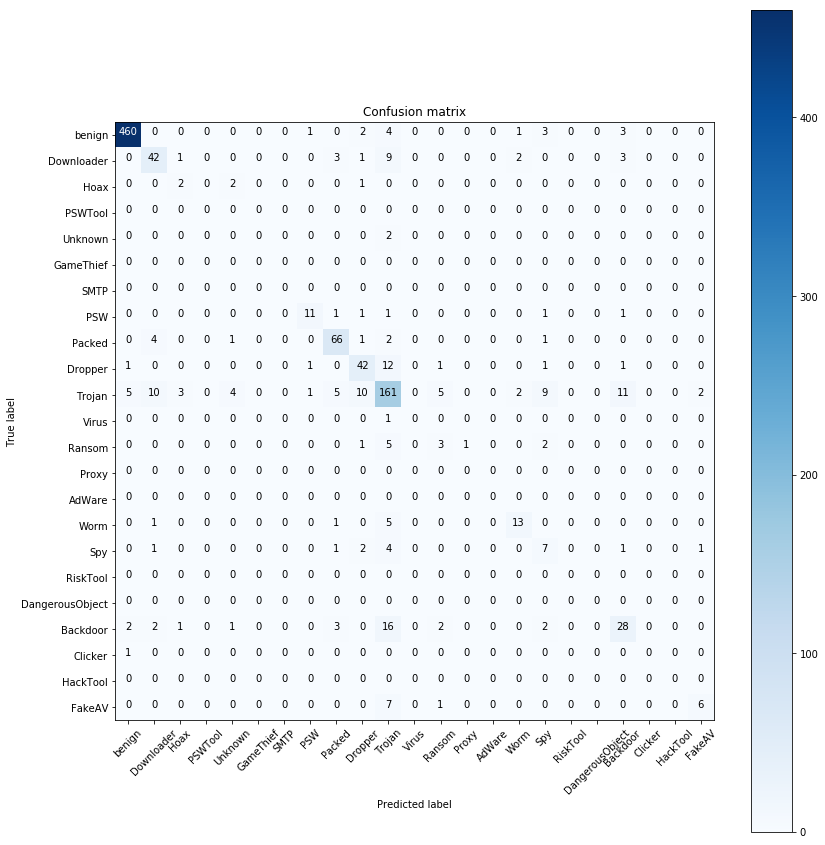

In [21]:
# Diffusion matrix를 그리기 위해서는 y_train, y_test가 multiclass여야합니다. one-hot vector는 multilabel로 취급됩니다.
# 따라서 convert_categorical_to_ohv = False 로 합니다.

# new_data_with_class에서 feature들은 컬럼 기준 0~67번 항목이고, 악성 코드 여부는 68번 항목, 악성 코드의 class는 69번 항목
x_train, y_train, x_test, y_test, num_features, num_classes = generate_training_and_test_data(new_data_with_class.values,
                                                                        np.arange(0, 68), 69,
                                                                        convert_categorical_to_ohv=False)
types = ['benign',] + uniq_kaspersky_short_types
y_pred = do_decision(x_train, y_train, x_test)
plt.figure(figsize = (12, 12))
print('DT accuracy: ', do_confusion(y_test, y_pred,
                                    labels = np.arange(0, len(uniq_kaspersky_short_types) + 1),
                                    classes = types))
print("f1 score: ", do_f1(y_test, y_pred))

## 3-2. RandomForest를 이용한 모델

이번에는 RandomForest를 이용한 모델입니다.

중간 결과로 출력되는 68개 항목을 가진 벡터(행렬)은, 68개의 feature가 결과에 얼마나 영향을 끼치는지를 계산한 값입니다. 이 값이 클 수록 결과에 미치는 영향이 큽니다. 즉, 더 **중요한** feature입니다. 이것에 대한 분석은 나중에...

[3.64527352e-03 3.70880966e-03 6.36905305e-04 7.53971606e-04
 1.11621763e-03 3.29765881e-02 2.05490050e-02 1.21446132e-03
 2.85198501e-02 0.00000000e+00 5.35828551e-03 6.16777863e-03
 0.00000000e+00 3.32890065e-04 2.20851254e-03 6.02006898e-04
 1.97799457e-03 4.14524479e-04 5.06104712e-04 0.00000000e+00
 7.27078921e-02 0.00000000e+00 2.36348576e-03 3.02834413e-02
 1.49898765e-02 4.15238462e-02 3.96671220e-02 1.10261248e-02
 5.39170813e-02 8.73681135e-03 3.41890149e-02 3.51417471e-03
 0.00000000e+00 0.00000000e+00 1.18444598e-02 6.99277952e-03
 1.60442070e-02 6.57766832e-03 1.14048112e-02 5.75834013e-03
 1.45264196e-03 4.49681840e-04 5.21344971e-02 1.16227192e-02
 2.47484990e-02 1.59689046e-05 2.73496074e-02 1.12917633e-05
 7.48118178e-03 0.00000000e+00 0.00000000e+00 8.33962602e-03
 1.49264488e-05 8.52948138e-07 0.00000000e+00 2.73791542e-02
 1.15122531e-02 2.32408118e-02 1.84792309e-02 3.68505775e-05
 2.23111710e-02 1.68288423e-02 5.22378489e-03 4.71765109e-02
 4.38966912e-02 5.500015

D:\Anaconda3\envs\keras\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


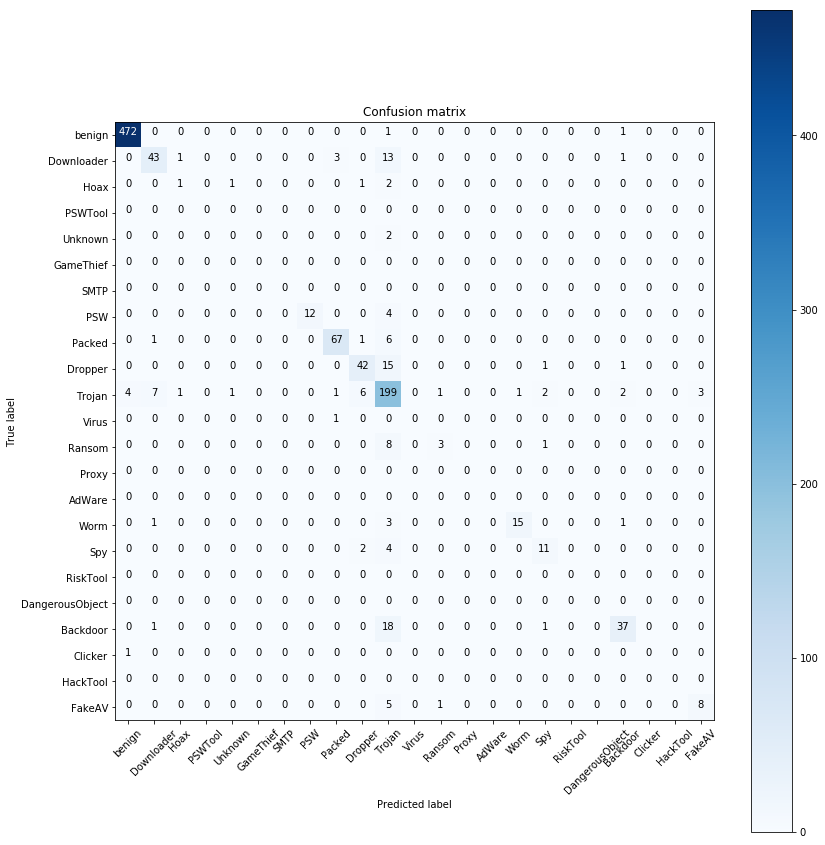

In [22]:
types = ['benign',] + uniq_kaspersky_short_types

y_pred = do_randomforest(x_train, y_train, x_test)
plt.figure(figsize = (12, 12))
print('DT accuracy: ', do_confusion(y_test, y_pred,
                                    labels = np.arange(0, len(uniq_kaspersky_short_types) + 1),
                                    classes = types))
print("f1 score: ", do_f1(y_test, y_pred))

보다시피, 간단한 문제에서는 신경망까지 안 가고 잘 정의된 기계학습 모델을 사용하는 것으로 충분합니다.

## 3-3. DNN을 이용한 모델

신경망을 이용한 모델을 만들어서 성능을 비교해 보겠습니다. 이번에는 multiclass 문제이므로, 신경망에서 이걸 잘 다루려면 y가 one-hot vector인 것이 좋으므로 학습 데이터를 새로 뽑습니다.

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
Input (InputLayer)                  (None, 68)                      0           
________________________________________________________________________________
dense_1 (Dense)                     (None, 20)                      1380        
________________________________________________________________________________
dense_2 (Dense)                     (None, 10)                      210         
________________________________________________________________________________
dense_3 (Dense)                     (None, 23)                      253         
________________________________________________________________________________
softmax_1 (Softmax)                 (None, 23)                      0           
Total params: 1,843
Trainable params: 1,843
Non-trainable params: 0
_________________________________________

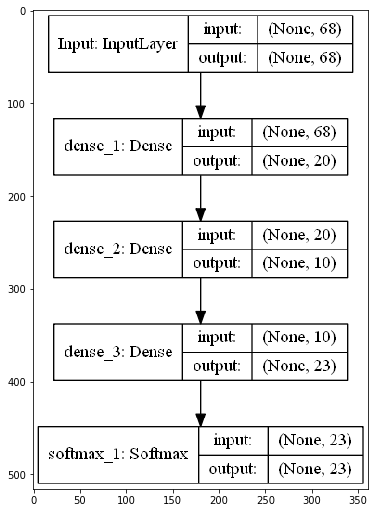

In [23]:
y_train_cate = keras.utils.to_categorical(y_train, len(uniq_kaspersky_short_types) + 1)
y_test_cate  = keras.utils.to_categorical(y_test,  len(uniq_kaspersky_short_types) + 1)

#간단한 모델
num_classes = len(uniq_kaspersky_short_types) + 1

inp = keras.layers.Input(shape = (num_features,), name = 'Input')
dense1 = keras.layers.Dense(20, activation = 'relu', name = 'dense_1')(inp)
dense2 = keras.layers.Dense(10, activation = 'relu', name = 'dense_2')(dense1)
dense3 = keras.layers.Dense(num_classes, name = 'dense_3')(dense2)
out = keras.layers.Softmax()(dense3)

first_model = keras.Model(inp, out, name = 'first_dnn_class')
first_model.compile(optimizer = keras.optimizers.adam(lr=0.001),
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy'])
first_model.summary(80)
plot_model(first_model, to_file='first_dnn_class.png', show_shapes = True, show_layer_names=True)
plt.figure(figsize = (6, 10))
plt.imshow(plt.imread('first_dnn_class.png'))

In [24]:
first_model.fit(x = x_train, y = y_train_cate,
                validation_data = [x_test, y_test_cate],
                initial_epoch = 0,
                epochs = 100)

Train on 4165 samples, validate on 1042 samples
Epoch 1/100
4165/4165 [==============================] - 2s 472us/step - loss: 2.2814 - acc: 0.3534 - val_loss: 1.6254 - val_acc: 0.4827
Epoch 2/100
4165/4165 [==============================] - 0s 110us/step - loss: 1.4538 - acc: 0.5741 - val_loss: 1.4248 - val_acc: 0.6008
Epoch 3/100
4165/4165 [==============================] - 0s 113us/step - loss: 1.3058 - acc: 0.6161 - val_loss: 1.3159 - val_acc: 0.6132
Epoch 4/100
4165/4165 [==============================] - 0s 110us/step - loss: 1.2229 - acc: 0.6343 - val_loss: 1.2486 - val_acc: 0.6324
Epoch 5/100
4165/4165 [==============================] - 0s 113us/step - loss: 1.1648 - acc: 0.6670 - val_loss: 1.1984 - val_acc: 0.6689
Epoch 6/100
4165/4165 [==============================] - 0s 116us/step - loss: 1.1125 - acc: 0.6898 - val_loss: 1.1434 - val_acc: 0.6718
Epoch 7/100
4165/4165 [==============================] - 0s 116us/step - loss: 1.0701 - acc: 0.7090 - val_loss: 1.1099 - val_acc: 

4165/4165 [==============================] - 0s 113us/step - loss: 0.7980 - acc: 0.7585 - val_loss: 0.8803 - val_acc: 0.7447
Epoch 61/100
4165/4165 [==============================] - 0s 113us/step - loss: 0.7939 - acc: 0.7599 - val_loss: 0.8845 - val_acc: 0.7342
Epoch 62/100
4165/4165 [==============================] - 0s 112us/step - loss: 0.7943 - acc: 0.7589 - val_loss: 0.8775 - val_acc: 0.7380
Epoch 63/100
4165/4165 [==============================] - 0s 113us/step - loss: 0.7950 - acc: 0.7618 - val_loss: 0.8781 - val_acc: 0.7418
Epoch 64/100
4165/4165 [==============================] - 0s 113us/step - loss: 0.7882 - acc: 0.7621 - val_loss: 0.8781 - val_acc: 0.7380
Epoch 65/100
4165/4165 [==============================] - 0s 114us/step - loss: 0.7904 - acc: 0.7597 - val_loss: 0.8766 - val_acc: 0.7351
Epoch 66/100
4165/4165 [==============================] - 0s 113us/step - loss: 0.7870 - acc: 0.7618 - val_loss: 0.8756 - val_acc: 0.7418
Epoch 67/100
4165/4165 [=======================

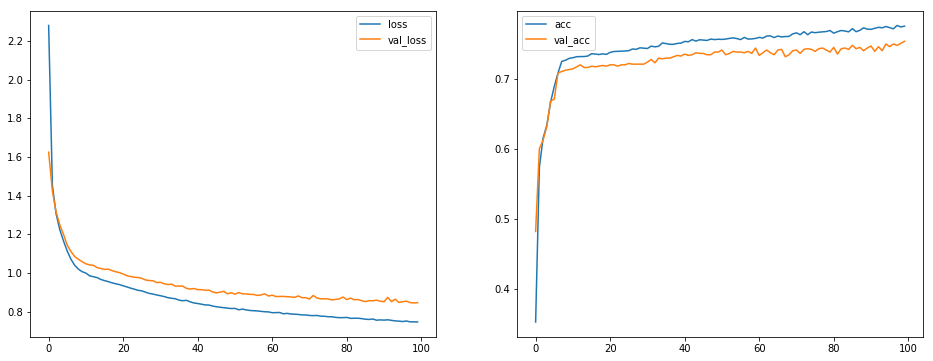

Confusion matrix, without normalization
DT accuracy:  0.7543186180422264
f1 score:  0.3007182816334265


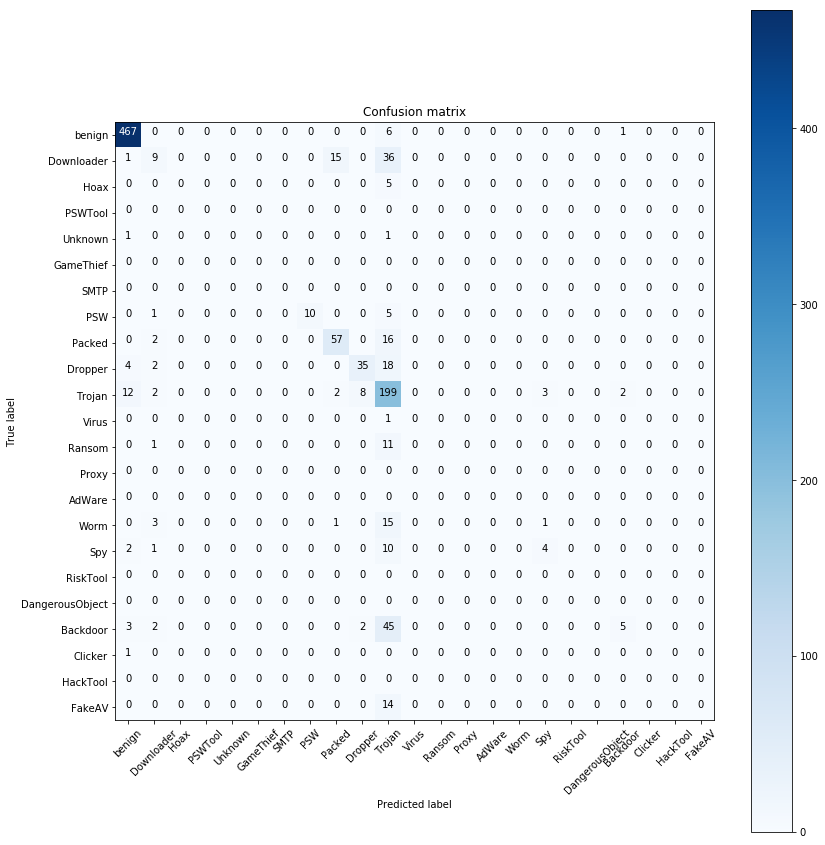

In [25]:
fig = plt.figure(figsize = (16, 6))
ax = plt.subplot(1, 2, 1)
ax.plot(first_model.history.history['loss'])
ax.plot(first_model.history.history['val_loss'])
ax.legend(['loss', 'val_loss'])
ax = plt.subplot(1, 2, 2)
ax.plot(first_model.history.history['acc'])
ax.plot(first_model.history.history['val_acc'])
ax.legend(['acc', 'val_acc'])
plt.show()

types = ['benign',] + uniq_kaspersky_short_types
y_pred = np.argmax(first_model.predict(x_test), axis = -1)

plt.figure(figsize = (12, 12))
print('DT accuracy: ', do_confusion(y_test, y_pred,
                                    labels = np.arange(0, len(uniq_kaspersky_short_types) + 1),
                                    classes = types))
print("f1 score: ", do_f1(y_test, y_pred))

생각보다 성능이 좋지는 않습니다.

사실 모델을 더 키우면 성능이 좋아지겠지만, 학습 자료의 개수가 많지 않아서 지금도 overfitting이 걱정되는 상황이라 모델을 키우기가 어렵습니다. 그래도 키워볼까요?

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
Input (InputLayer)                  (None, 68)                      0           
________________________________________________________________________________
dense_1 (Dense)                     (None, 40)                      2760        
________________________________________________________________________________
dense_2 (Dense)                     (None, 20)                      820         
________________________________________________________________________________
dense_3 (Dense)                     (None, 20)                      420         
________________________________________________________________________________
dense_4 (Dense)                     (None, 23)                      483         
________________________________________________________________________________
softmax_3 (Softmax)         

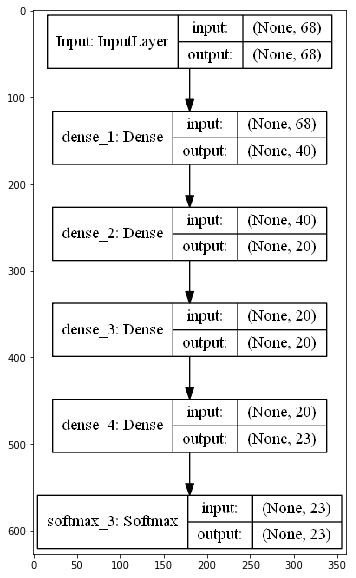

In [27]:
#간단한 모델

inp = keras.layers.Input(shape = (num_features,), name = 'Input')
dense1 = keras.layers.Dense(40, activation = 'relu', name = 'dense_1')(inp)
dense2 = keras.layers.Dense(20, activation = 'relu', name = 'dense_2')(dense1)
dense3 = keras.layers.Dense(20, activation = 'relu', name = 'dense_3')(dense2)
dense4 = keras.layers.Dense(num_classes, name = 'dense_4')(dense3)
out = keras.layers.Softmax()(dense4)

second_model = keras.Model(inp, out, name = 'second_dnn_class')
second_model.compile(optimizer = keras.optimizers.adam(lr=0.001),
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy'])
second_model.summary(80)
plot_model(second_model, to_file='second_dnn_class.png', show_shapes = True, show_layer_names=True)
plt.figure(figsize = (6, 10))
plt.imshow(plt.imread('second_dnn_class.png'))

In [28]:
second_model.fit(x = x_train, y = y_train_cate,
                validation_data = [x_test, y_test_cate],
                initial_epoch = 0,
                epochs = 100)

Train on 4165 samples, validate on 1042 samples
Epoch 1/100
4165/4165 [==============================] - 1s 203us/step - loss: 1.8985 - acc: 0.4819 - val_loss: 1.3563 - val_acc: 0.6017
Epoch 2/100
4165/4165 [==============================] - 1s 132us/step - loss: 1.1946 - acc: 0.6595 - val_loss: 1.1792 - val_acc: 0.6555
Epoch 3/100
4165/4165 [==============================] - 1s 136us/step - loss: 1.0704 - acc: 0.6977 - val_loss: 1.0834 - val_acc: 0.7063
Epoch 4/100
4165/4165 [==============================] - 1s 134us/step - loss: 1.0136 - acc: 0.7229 - val_loss: 1.0336 - val_acc: 0.7121
Epoch 5/100
4165/4165 [==============================] - 1s 133us/step - loss: 0.9762 - acc: 0.7311 - val_loss: 1.0220 - val_acc: 0.7121
Epoch 6/100
4165/4165 [==============================] - 1s 132us/step - loss: 0.9465 - acc: 0.7349 - val_loss: 0.9881 - val_acc: 0.7169
Epoch 7/100
4165/4165 [==============================] - 1s 130us/step - loss: 0.9315 - acc: 0.7359 - val_loss: 0.9682 - val_acc: 

4165/4165 [==============================] - 1s 133us/step - loss: 0.6801 - acc: 0.7866 - val_loss: 0.8188 - val_acc: 0.7591
Epoch 61/100
4165/4165 [==============================] - 1s 132us/step - loss: 0.6784 - acc: 0.7906 - val_loss: 0.8245 - val_acc: 0.7438
Epoch 62/100
4165/4165 [==============================] - 1s 134us/step - loss: 0.6815 - acc: 0.7866 - val_loss: 0.8198 - val_acc: 0.7591
Epoch 63/100
4165/4165 [==============================] - 1s 133us/step - loss: 0.6754 - acc: 0.7911 - val_loss: 0.8350 - val_acc: 0.7505
Epoch 64/100
4165/4165 [==============================] - 1s 134us/step - loss: 0.6737 - acc: 0.7897 - val_loss: 0.8089 - val_acc: 0.7697
Epoch 65/100
4165/4165 [==============================] - 1s 132us/step - loss: 0.6732 - acc: 0.7909 - val_loss: 0.8100 - val_acc: 0.7534
Epoch 66/100
4165/4165 [==============================] - 1s 135us/step - loss: 0.6778 - acc: 0.7861 - val_loss: 0.8406 - val_acc: 0.7514
Epoch 67/100
4165/4165 [=======================

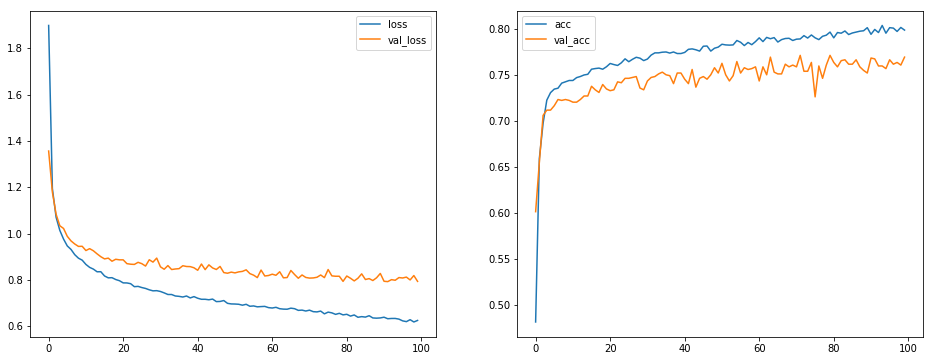

Confusion matrix, without normalization
DT accuracy:  0.7696737044145874
f1 score:  0.33923670005355056


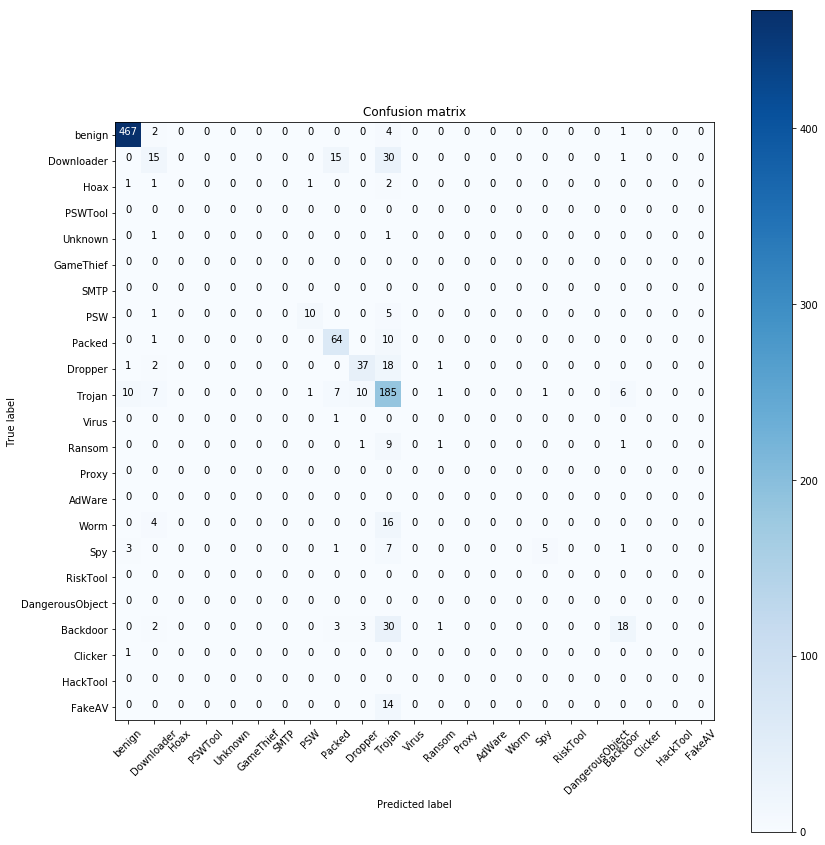

In [29]:
fig = plt.figure(figsize = (16, 6))
ax = plt.subplot(1, 2, 1)
ax.plot(second_model.history.history['loss'])
ax.plot(second_model.history.history['val_loss'])
ax.legend(['loss', 'val_loss'])
ax = plt.subplot(1, 2, 2)
ax.plot(second_model.history.history['acc'])
ax.plot(second_model.history.history['val_acc'])
ax.legend(['acc', 'val_acc'])
plt.show()

types = ['benign',] + uniq_kaspersky_short_types
y_pred = np.argmax(second_model.predict(x_test), axis = -1)

plt.figure(figsize = (12, 12))
print('DT accuracy: ', do_confusion(y_test, y_pred,
                                    labels = np.arange(0, len(uniq_kaspersky_short_types) + 1),
                                    classes = types))
print("f1 score: ", do_f1(y_test, y_pred))

# 결론 : 다시 한 번 알게되는 사실은, 신경망이 능사는 아닙니다.